MolFromSmiles OK? True
Loaded ESOL from: https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Columns found: ['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'measured log solubility in mols per litre', 'smiles']
Missing values per column:
 SMILES    0
logS      0
MolWt     0
LogP      0
HBD       0
HBA       0
dtype: int64


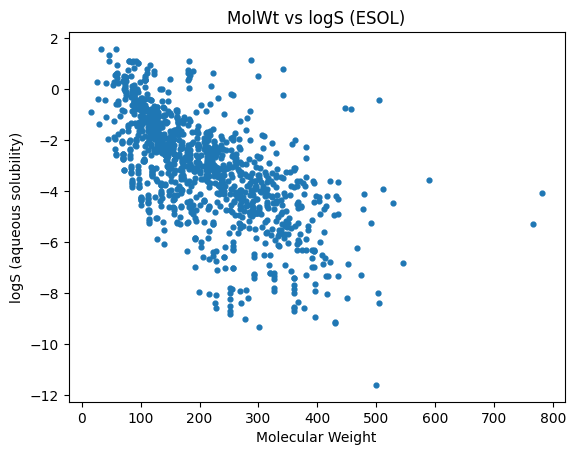

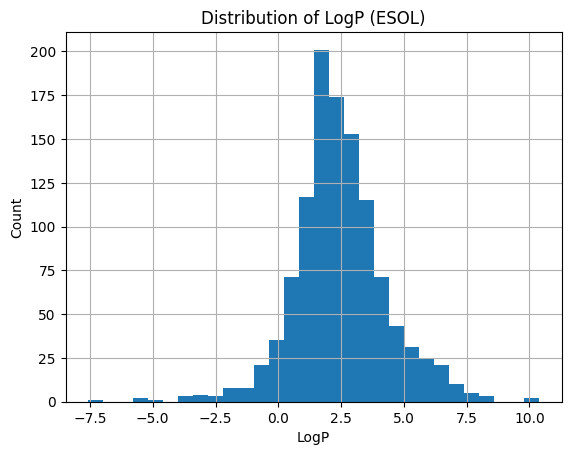

R^2 on test: 0.741


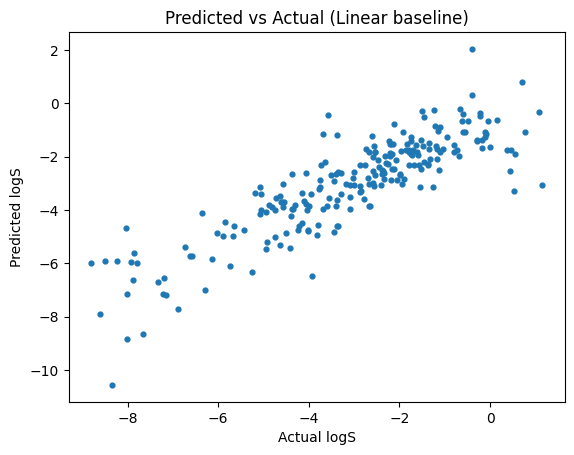

Coefficients:
 HBA      0.027
MolWt   -0.005
HBD     -0.206
LogP    -0.845
dtype: float64
Intercept: 0.225
Saved files:
 - esol_descriptors_and_logS.csv
 - molwt_vs_logS.png
 - logp_hist.png
 - predicted_vs_actual.png


In [23]:
# Install RDKit into the Colab runtime
!pip -q install kora
import kora.install.rdkit  # this line installs RDKit from conda-forge under the hood

# Sanity check: imports + simple call
from rdkit import Chem, RDLogger
RDLogger.DisableLog('rdApp.*')  # silence RDKit warnings
mol = Chem.MolFromSmiles("CCO")  # ethanol
print("MolFromSmiles OK?", mol is not None)
import pandas as pd, numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

%matplotlib inline
import io

esol_urls = [
    "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv",
    "https://raw.githubusercontent.com/chemprop/chemprop/master/data/delaney/delaney.csv",
    "https://raw.githubusercontent.com/wujr5/moleculenet/master/datasets/delaney/delaney-processed.csv",
]

df = None
last_err = None
for url in esol_urls:
    try:
        tmp = pd.read_csv(url)
        df = tmp.copy()
        print(f"Loaded ESOL from: {url}")
        break
    except Exception as e:
        last_err = e

if df is None:
    print("Auto-download failed. Upload a CSV with SMILES + solubility column.")
    from google.colab import files
    up = files.upload()
    fname = next(iter(up))
    df = pd.read_csv(io.BytesIO(up[fname]))

print("Columns found:", list(df.columns))
df.columns = [c.lower() for c in df.columns]

smiles_col_candidates = ["smiles", "smile", "structure"]
sol_cols = [
    "measured log solubility in mols per litre",
    "measured log solubility in mols/litre",
    "measured log solubility in mols/l",
    "logsolubility", "solubility", "log_s"
]

def find_col(cands, cols):
    for c in cands:
        if c in cols:
            return c
    return None

smiles_col = find_col(smiles_col_candidates, set(df.columns))
sol_col    = find_col(sol_cols, set(df.columns))
if smiles_col is None or sol_col is None:
    raise ValueError("Could not find SMILES or solubility column.")

df = df[[smiles_col, sol_col]].dropna().rename(columns={smiles_col:"SMILES", sol_col:"logS"})
df.head()
def calc_descriptors(smiles: str):
    mol = Chem.MolFromSmiles(smiles)  # correct name: MolFromSmiles (lowercase 'miles')
    if mol is None:
        return pd.Series([np.nan]*4, index=['MolWt','LogP','HBD','HBA'])
    return pd.Series({
        'MolWt': Descriptors.MolWt(mol),
        'LogP':  Descriptors.MolLogP(mol),
        'HBD':   Descriptors.NumHDonors(mol),
        'HBA':   Descriptors.NumHAcceptors(mol),
    })

df[['MolWt','LogP','HBD','HBA']] = df['SMILES'].apply(calc_descriptors)
df = df.dropna(subset=['MolWt','LogP','HBD','HBA','logS']).reset_index(drop=True)
df.head()
print("Missing values per column:\n", df.isna().sum())

plt.figure()
plt.scatter(df['MolWt'], df['logS'], s=12)
plt.xlabel('Molecular Weight'); plt.ylabel('logS (aqueous solubility)')
plt.title('MolWt vs logS (ESOL)')
plt.savefig('molwt_vs_logS.png', dpi=180, bbox_inches='tight')
plt.show()

plt.figure()
df['LogP'].hist(bins=30)
plt.xlabel('LogP'); plt.ylabel('Count')
plt.title('Distribution of LogP (ESOL)')
plt.savefig('logp_hist.png', dpi=180, bbox_inches='tight')
plt.show()
X = df[['MolWt','LogP','HBD','HBA']]
y = df['logS']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression().fit(X_tr, y_tr)
y_pred = model.predict(X_te)

print(f"R^2 on test: {r2_score(y_te, y_pred):.3f}")

plt.figure()
plt.scatter(y_te, y_pred, s=12)
plt.xlabel('Actual logS'); plt.ylabel('Predicted logS')
plt.title('Predicted vs Actual (Linear baseline)')
plt.savefig('predicted_vs_actual.png', dpi=180, bbox_inches='tight')
plt.show()

coef = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)
print("Coefficients:\n", coef.round(3))
print("Intercept:", round(model.intercept_, 3))
df.to_csv('esol_descriptors_and_logS.csv', index=False)
print("Saved files:")
for f in ['esol_descriptors_and_logS.csv', 'molwt_vs_logS.png', 'logp_hist.png', 'predicted_vs_actual.png']:
    print(" -", f)




## Load the Dataset

In [24]:
# Load the dataset (Assuming the dataset is available at this path. You might need to adjust the path.)
# Example dataset structure: SMILES, LogS (solubility)
try:
    df = pd.read_csv('delaney-processed.csv') # Replace with the actual dataset filename if different
    display(df.head())
except FileNotFoundError:
    print("Error: Dataset file not found. Please upload the dataset file or provide the correct path.")
    # You might need to add code here to download the dataset if it's publicly available

Error: Dataset file not found. Please upload the dataset file or provide the correct path.
